# Training an SNN with fewer synops
Similar as in the previous tutorial, we start by defining a spiking model. 

In [1]:
import torch
import torch.nn as nn
import sinabs
import sinabs.layers as sl

class SNN(nn.Sequential):
    def __init__(self, batch_size):
        super().__init__(
            sl.FlattenTime(),
            nn.Conv2d(1, 16, 5, bias=False),
            sl.IAFSqueeze(batch_size=batch_size),
            sl.SumPool2d(2),
            nn.Conv2d(16, 32, 5, bias=False),
            sl.IAFSqueeze(batch_size=batch_size),
            sl.SumPool2d(2),
            nn.Conv2d(32, 120, 4, bias=False),
            sl.IAFSqueeze(batch_size=batch_size),
            nn.Flatten(),
            nn.Linear(120, 10, bias=False),
            sl.IAFSqueeze(batch_size=batch_size),
            sl.UnflattenTime(batch_size=batch_size),
        )

batch_size = 5
snn = SNN(batch_size=batch_size)
snn

SNN(
  (0): FlattenTime(start_dim=0, end_dim=1)
  (1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (2): IAFSqueeze(spike_threshold=1.0, batch_size=5, num_timesteps=-1)
  (3): SumPool2d(norm_type=1, kernel_size=2, stride=None, ceil_mode=False)
  (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (5): IAFSqueeze(spike_threshold=1.0, batch_size=5, num_timesteps=-1)
  (6): SumPool2d(norm_type=1, kernel_size=2, stride=None, ceil_mode=False)
  (7): Conv2d(32, 120, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (8): IAFSqueeze(spike_threshold=1.0, batch_size=5, num_timesteps=-1)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=120, out_features=10, bias=False)
  (11): IAFSqueeze(spike_threshold=1.0, batch_size=5, num_timesteps=-1)
  (12): UnflattenTime()
)

The `SNNAnalyzer` class tracks different statistics for spiking (such as IAF/LIF) and parameter (such as Conv2d/Linear) layers. The number of synaptic operations is part of the parameter layers. If we attach such an analyzer to the model, we'll be able to use layer- or model-wide statistics during training, for optimization or logging purposes.

In [2]:
analyzer = sinabs.SNNAnalyzer(snn)
print(f"Synops before feeding input: {analyzer.get_model_statistics()['synops']}")

rand_input_spikes = (torch.ones((batch_size, 10, 1, 28, 28)) ).float()
y_hat = snn(rand_input_spikes)
print(f"Synops after feeding input: {analyzer.get_model_statistics()['synops']}")

Synops before feeding input: 0.0
Synops after feeding input: 37335420.0


You can break down the statistics for each layer:

In [35]:
layer_stats = analyzer.get_layer_statistics()

for layer_name in layer_stats.keys():
    print(f"Layer {layer_name} tracks statistics {layer_stats[layer_name].keys()}")

Layer 1 tracks statistics dict_keys(['input', 'fanout_prev', 'synops', 'num_timesteps', 'time_window', 'SynOps/s'])
Layer 2 tracks statistics dict_keys(['firing_rate', 'firing_rate_per_neuron', 'n_neurons'])
Layer 4 tracks statistics dict_keys(['input', 'fanout_prev', 'synops', 'num_timesteps', 'time_window', 'SynOps/s'])
Layer 5 tracks statistics dict_keys(['firing_rate', 'firing_rate_per_neuron', 'n_neurons'])
Layer 7 tracks statistics dict_keys(['input', 'fanout_prev', 'synops', 'num_timesteps', 'time_window', 'SynOps/s'])
Layer 8 tracks statistics dict_keys(['firing_rate', 'firing_rate_per_neuron', 'n_neurons'])
Layer 10 tracks statistics dict_keys(['input', 'fanout_prev', 'synops', 'num_timesteps', 'time_window', 'SynOps/s'])
Layer 11 tracks statistics dict_keys(['firing_rate', 'firing_rate_per_neuron', 'n_neurons'])


Once we can calculate the total number synops, we might want to choose a target synops number as part of our objective function. If we set the number to low, the network will fail to learn anything as there won't be any activity at all. As a rule of thumb, do a training run without adding synops to your loss at first and observe how the numbers evolve. You can then set a target synops number accordingly. 

In this tutorial we're going to only optimise for number of synaptic operations given a constant input. We set the target to twice the number of operations of the untrained network. We log the number of synops over time and also the average firing rate in the network, which is closely related.

In [4]:
# Find out the target number of operations
target_synops = 2 * analyzer.get_model_statistics()['synops'].detach_()

optim = torch.optim.Adam(snn.parameters(), lr=1e-3)

n_synops = []
firing_rates = []
for epoch in range(100):
    sinabs.reset_states(snn)
    sinabs.zero_grad(snn)
    optim.zero_grad()
    
    snn(rand_input_spikes)

    model_stats = analyzer.get_model_statistics()
    synops = model_stats['synops']
    firing_rate = model_stats['firing_rate']
    n_synops.append(synops.detach().cpu().numpy())
    firing_rates.append(firing_rate.detach().cpu().numpy())
    
    synops_loss = (target_synops - synops).square() / target_synops.square()
    synops_loss.backward()
    optim.step()


Text(0.5, 0, 'Epoch')

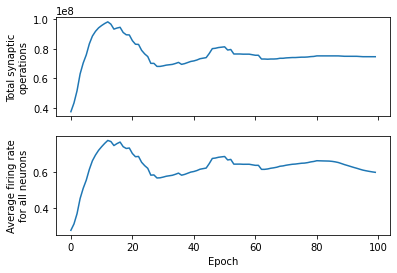

In [6]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(n_synops)
ax1.set_ylabel("Total synaptic\noperations")

ax2.plot(firing_rates)
ax2.set_ylabel("Average firing rate\nacross all neurons")

ax2.set_xlabel("Epoch")

Using the Adam optimizer, which uses a form of momentum, we can see that the network quickly optimizes for the target number of synaptic operations. Closely related (although always between 0 and 1) is the average firing rate for all neurons. Additionally, we can also plot some statistics for each layer:

In [32]:
layer_stats = analyzer.get_layer_statistics()

for layer_name in ['2', '5', '8', '11']:
    print(f"Layer {layer_name} has {layer_stats[layer_name]['n_neurons']} neurons.")

Layer 2 has 9216 neurons.
Layer 5 has 2048 neurons.
Layer 8 has 120 neurons.
Layer 11 has 10 neurons.


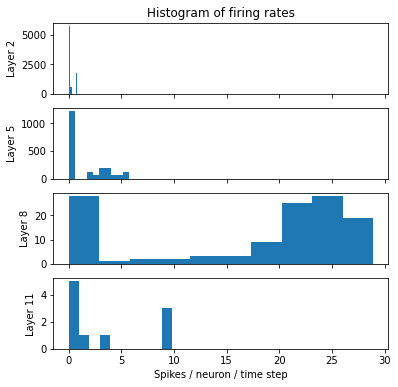

In [33]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(6,6))

for axis, layer_name in zip(axes, ['2', '5', '8', '11']):
    axis.hist(layer_stats[layer_name]['firing_rate_per_neuron'].detach().numpy().ravel(), bins=10)
    axis.set_ylabel(f"Layer {layer_name}")
axes[0].set_title("Histogram of firing rates")
axes[-1].set_xlabel("Spikes / neuron / time step");